In [70]:
import sys
import csv
import re
import pprint
import fastText
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from bs4 import BeautifulSoup
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [71]:
# Test parts for data preparation; not used eventually
# from nltk.corpus import stopwords
# stop_words = stopwords.words("dutch")
#         tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweet).split()) # remove hastags and mentions
#         tweet = ' '.join(re.sub("[\'\.\,\!\?\:\;\-\=\(\)\[\]\{\}\\\<\>\/\?\@\#$#\%\^\&\*\_\~\"]", " ", tweet).split()) # remove punctuation
#         tweet = remove_emoji(tweet)
#     df["cleaned"] = df["cleaned"].str.split()
#     df["cleaned"].apply(lambda x: [item for item in x if item not in stop_words]) # remove stopwords
#     df["cleaned"] = [" ".join(x) for x in df["cleaned"]]

# Prepare data

In [72]:
def preprocess(df):
    df["cleaned"] = ""
    processed_text = []
    for text in df["text"]:
        text = BeautifulSoup(text).get_text() # transforms things like &amp to &
        text = text.lower()
        text = ' '.join(re.sub("(@[A-Za-z0-9]+)", "MENTION", text).split()) # replace mentions with "MENTION" in tweets
        text = ' '.join(re.sub("(\/u\/[A-Za-z0-9]+)", "MENTION", text).split()) # replace mentions with "MENTION" in Reddit Comments. Example: /u/username
        text = ' '.join(re.sub("(u\/[A-Za-z0-9]+)", "MENTION", text).split()) # replace mentions with "MENTION" in Reddit Comments. Example: u/username
        text = ' '.join(re.sub("#", " ", text).split()) # remove # symbols    
        text = ' '.join(re.sub("(\w+:\/\/\S+)", "URL", text).split()) # replace links/URLs with "URL"
        processed_text.append(text)
         
    df["cleaned"] = processed_text

    return df["cleaned"]

def replacer(input_file):
    df = pd.read_csv(input_file, sep='\t', encoding="utf8")
    df["cleaned"] = preprocess(df) # add processed text to a new column "cleaned" and add this to the dataframe
    
    # replace all EXPLICIT and IMPLICIT labels with OFFENSIVE
    df["explicitness"] = df["explicitness"].replace(["EXPLICIT", "IMPLICIT"], "OFFENSIVE")

    print(df["explicitness"].value_counts())
    
    # transform labels with LabelEncoder
    # 0 = NOT
    # 1 = OFFENSIVE
    df["explicitness"] = df["explicitness"].astype(str)
    df["explicitness"] = LabelEncoder().fit_transform(df["explicitness"])

    return df       

In [73]:
print("Train:")
train_df = replacer("train_final.csv")

print("Dev:")
dev_df = replacer("dev_final.csv")

print("Test:")
test_df = replacer("test_final.csv")

print(train_df["text"].head())
print(train_df["cleaned"].head())

Train:
NOT          5176
OFFENSIVE    2588
Name: explicitness, dtype: int64
Dev:
NOT          361
OFFENSIVE    186
Name: explicitness, dtype: int64
Test:
NOT          2072
OFFENSIVE    1036
Name: explicitness, dtype: int64
0    @StuiverAnne @LodewijkA Iets anders, wanneer w...
1    @GUnight fucking schaamteloos! Je kunt de Afri...
2    Mijn hemel! De elite, diegenen die onze cultuu...
3    het feit dat mensen nog steeds zwarte piet sup...
4    @GerardKrolNL @groenlinks het is goed te zien ...
Name: text, dtype: object
0    MENTION MENTION iets anders, wanneer word assc...
1    MENTION fucking schaamteloos! je kunt de afrik...
2    mijn hemel! de elite, diegenen die onze cultuu...
3    het feit dat mensen nog steeds zwarte piet sup...
4    MENTION MENTION het is goed te zien dat grlink...
Name: cleaned, dtype: object


In [74]:
# vectorize words using tf_idf for SVM
tf_idf = TfidfVectorizer()
# print(tf_idf.get_feature_names())
X_train = pd.DataFrame(tf_idf.fit_transform(train_df["cleaned"]).toarray())

tf_idf2 = TfidfVectorizer(vocabulary = tf_idf.get_feature_names())
X_test = pd.DataFrame(tf_idf2.fit_transform(test_df["cleaned"]).toarray())

print(X_train.shape)
print(X_test.shape)

(7764, 20956)
(3108, 20956)


# Apply LinearSVC

In [75]:
np.random.seed(1)

y_train = train_df["explicitness"].copy()

y_test = test_df["explicitness"].copy()

model = svm.LinearSVC(loss="hinge")

model.fit(X_train, y_train)
print(model.score(X_test, y_test)) # 0.8127413127413128

f1_score(y_test, model.predict(X_test), average='macro')
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

0.8127413127413128
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2072
           1       0.79      0.59      0.68      1036

    accuracy                           0.81      3108
   macro avg       0.81      0.76      0.77      3108
weighted avg       0.81      0.81      0.80      3108



[[1910  162]
 [ 420  616]]


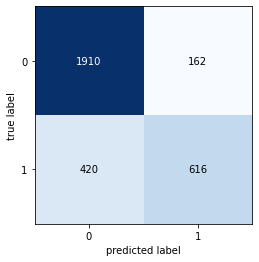

In [76]:
y_target = y_test
y_predicted = y_pred

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

# Add prefix to work with fasttext

In [77]:
def add_prefix(dataframe, output_file):

    f_rows = []

    # add required prefix for fasttext
    for index, row in dataframe.iterrows():
        fasttext_row = f"{'__label__' + str(row['explicitness'])} {row['cleaned']}"
        f_rows.append(fasttext_row)
        
    fasttext_df = pd.DataFrame(f_rows)
    
    return fasttext_df.to_csv(output_file, index=False, header=False, encoding="utf-8", 
                              quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")

In [78]:
print("Adding prefixes to data...")
fasttext_df_train = add_prefix(train_df, 'train.txt')
fasttext_df_dev = add_prefix(dev_df, 'dev.txt')
fasttext_df_test = add_prefix(test_df, 'test.txt')
print("Done!")

Adding prefixes to data...
Done!


# Train fasttext model

In [79]:
# print("Training fasttext model...")
# f_model = fastText.train_supervised(input="train.txt",  
#                                     autotuneValidationFile="dev.txt", 
#                                     autotuneMetric="f1:__label__1", 
#                                     autotuneDuration=900)
# print("Done! Saving the model now...")
# f_model.save_model("fasttext_model_binary.bin")
# print("The model is saved as 'fasttext_model_binary.bin'.")

print("Loading fasttext model...")
f_model = fastText.load_model("fasttext_model_binary.bin")
print("Model loaded succesfully!")

# the part below is used to print out the arguments of the autotunoValidation
print("The paramaters used for the fastText model are:\n")
args_obj = f_model.f.getArgs()
for hparam in dir(args_obj):
    if not hparam.startswith('__'):
        print(f"{hparam} -> {getattr(args_obj, hparam)}")

Loading fasttext model...
Model loaded succesfully!
The paramaters used for the fastText model are:

autotuneDuration -> 300
autotuneMetric -> f1
autotuneModelSize -> 
autotunePredictions -> 1
autotuneValidationFile -> 
bucket -> 3869285
cutoff -> 0
dim -> 199
dsub -> 2
epoch -> 9
input -> 
label -> __label__
loss -> loss_name.softmax
lr -> 0.05
lrUpdateRate -> 100
maxn -> 5
minCount -> 1
minCountLabel -> 0
minn -> 2
model -> model_name.supervised
neg -> 5
output -> 
pretrainedVectors -> 
qnorm -> False
qout -> False
retrain -> False
saveOutput -> False
seed -> 0
setManual -> <bound method PyCapsule.setManual of <fasttext_pybind.args object at 0x0000029F4E7612F0>>
t -> 0.0001
thread -> 12
verbose -> 2
wordNgrams -> 2
ws -> 5


In [80]:
f_model.get_nearest_neighbors("halsema")

[(0.9999803900718689, 'halalsema'),
 (0.9999688863754272, 'gorelinksehalsema'),
 (0.9999602437019348, 'femkehalsema'),
 (0.999958872795105, 'halsema!'),
 (0.9999585151672363, 'halsemaout'),
 (0.9999548196792603, 'shit'),
 (0.9999511241912842, 'shit.'),
 (0.9999502897262573, 'halalsema!'),
 (0.9999496340751648, 'idioot!'),
 (0.9999493956565857, 'tuig')]

In [81]:
# get all labels with probability higher or equal to 0.5
test_sentence = "wij zijn een stel idioten"
f_model.predict(test_sentence,  k=-1, threshold=0.5)

(('__label__1',), array([1.00000942]))

# Test model on reddit comments

In [82]:
reddit_df = pd.read_csv("reddit_comments.csv", sep=',', encoding="utf8")

preprocess(reddit_df)

reddit_df_test = add_prefix(reddit_df, 'reddit_test.txt')

In [83]:
def fasttext_model_test(input_file):

    predictions = []

    with open(input_file, encoding="utf8") as f:
        for line in f:
            # check the text, ignore label if label == nan
            test_sentence = line[14:].rstrip()
            predictions.append(f_model.predict(test_sentence,  k=-1, threshold=0.5))

    return predictions, test_sentence 

In [84]:
# predict labels with fastText
test = fasttext_model_test("reddit_test.txt")

# print(reddit_df["explicitness"])
# add every predicted label to the dataframe by changing 'NaN' to '__label__X' where X is 0 or 1
reddit_df["explicitness"] = [str(label[0])[2:-3] for label in test[0]]
# print(reddit_df["explicitness"])

# save the labels and processed text to a file for manual annotation
reddit_df[["explicitness", "cleaned"]].to_csv("reddit_test_labeled.txt", index=False, header=False, encoding="utf-8", 
                                              quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ", sep =" ")
# label distribution after prediction
reddit_df["explicitness"] = reddit_df["explicitness"].replace(["__label__1"], "OFFENSIVE")
reddit_df["explicitness"] = reddit_df["explicitness"].replace(["__label__0"], "NOT")

print(reddit_df["explicitness"].value_counts())

NOT          394
OFFENSIVE    131
Name: explicitness, dtype: int64


In [85]:
# __label__0 = NOT
# __label__1 = OFFENSIVE

# The precision is the number of correct labels among the labels predicted by fastText. 
# The recall is the number of labels that successfully were predicted, among all the real labels.

results = f_model.test_label("test.txt")
print("Results per label:")
pprint.pprint(results)

#15
# {'__label__0': {'f1score': 0.8648777012586084,
#                 'precision': 0.8513323983169705,
#                 'recall': 0.8788610038610039},
#  '__label__1': {'f1score': 0.7162094763092269,
#                 'precision': 0.7409700722394221,
#                 'recall': 0.693050193050193}}
#30
# {'__label__0': {'f1score': 0.8638914873713751,
#                 'precision': 0.838021778584392,
#                 'recall': 0.8914092664092664},
#  '__label__1': {'f1score': 0.7,
#                 'precision': 0.7511061946902655,
#                 'recall': 0.6554054054054054}}
#10
# {'__label__0': {'f1score': 0.8690587138863001,
#                 'precision': 0.8400900900900901,
#                 'recall': 0.900096525096525},
#  '__label__1': {'f1score': 0.7079002079002079,
#                 'precision': 0.7668918918918919,
#                 'recall': 0.6573359073359073}}

Results per label:
{'__label__0': {'f1score': 0.8648777012586084,
                'precision': 0.8513323983169705,
                'recall': 0.8788610038610039},
 '__label__1': {'f1score': 0.7162094763092269,
                'precision': 0.7409700722394221,
                'recall': 0.693050193050193}}
